# Generalized Additive Models for Regression

**Generalized Additive Models (GAMs)** extend linear models by allowing non-linear relationships:

$$E(Y \mid X) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)$$

where $f_j$ are smooth functions estimated using penalized splines.

**Key Properties**:
- **Additivity**: Each predictor contributes independently (interpretable)
- **Flexibility**: Captures non-linear patterns automatically
- **Backfitting Algorithm**: Iteratively estimates each $f_j$ given others
- **Effective Degrees of Freedom**: Quantifies model complexity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from gam import GAM
from data_utils import load_fev_data, get_fev_data_summary
from utils import mean_squared_error, r_squared, plot_qq_plot

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

np.random.seed(42)

## 1. Data Exploration

### Dataset: FEV (Forced Expiratory Volume)

**Objective**: Predict lung function (FEV) from demographic and behavioral variables.

**Variables**:
- **FEV** (response): Forced expiratory volume in liters (continuous)
- **Age**: Age in years (expect non-linear growth pattern)
- **Height**: Height in inches (expect linear relationship)
- **Sex**: Male (1) or Female (0)
- **Smoke**: Smoker (1) or Non-smoker (0)

**Sample Size**: 654 observations

In [2]:
X_train, X_test, y_train, y_test, features = load_fev_data(
    filepath='fev.csv',
    standardize=True,
    test_size=0.2,
    random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeatures:\n{features}")

summary = get_fev_data_summary('fev.csv')
print(f"\nDataset Summary:\n{summary}")

Training set: (523, 4)
Test set: (131, 4)

Features:
  feature         type                                description
0     age   continuous                               Age in years
1  height   continuous                           Height in inches
2     sex  categorical                  Gender (1=male, 0=female)
3   smoke  categorical  Smoking status (1=non-current, 0=current)

Dataset Summary:
                           age         fev      height
count               654.000000  654.000000  654.000000
mean                  9.931193    2.636780   61.143578
std                   2.953935    0.867059    5.703513
min                   3.000000    0.791000   46.000000
25%                   8.000000    1.981000   57.000000
50%                  10.000000    2.547500   61.500000
75%                  12.000000    3.118500   65.500000
max                  19.000000    5.793000   74.000000
missing               0.000000    0.000000    0.000000
sex: female         318.000000  318.000000  318.0

/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_97763/490445640.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df[df['sex'] == 0]['fev'], df[df['sex'] == 1]['fev']],
/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_97763/490445640.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df[df['smoke'] == 0]['fev'], df[df['smoke'] == 1]['fev']],


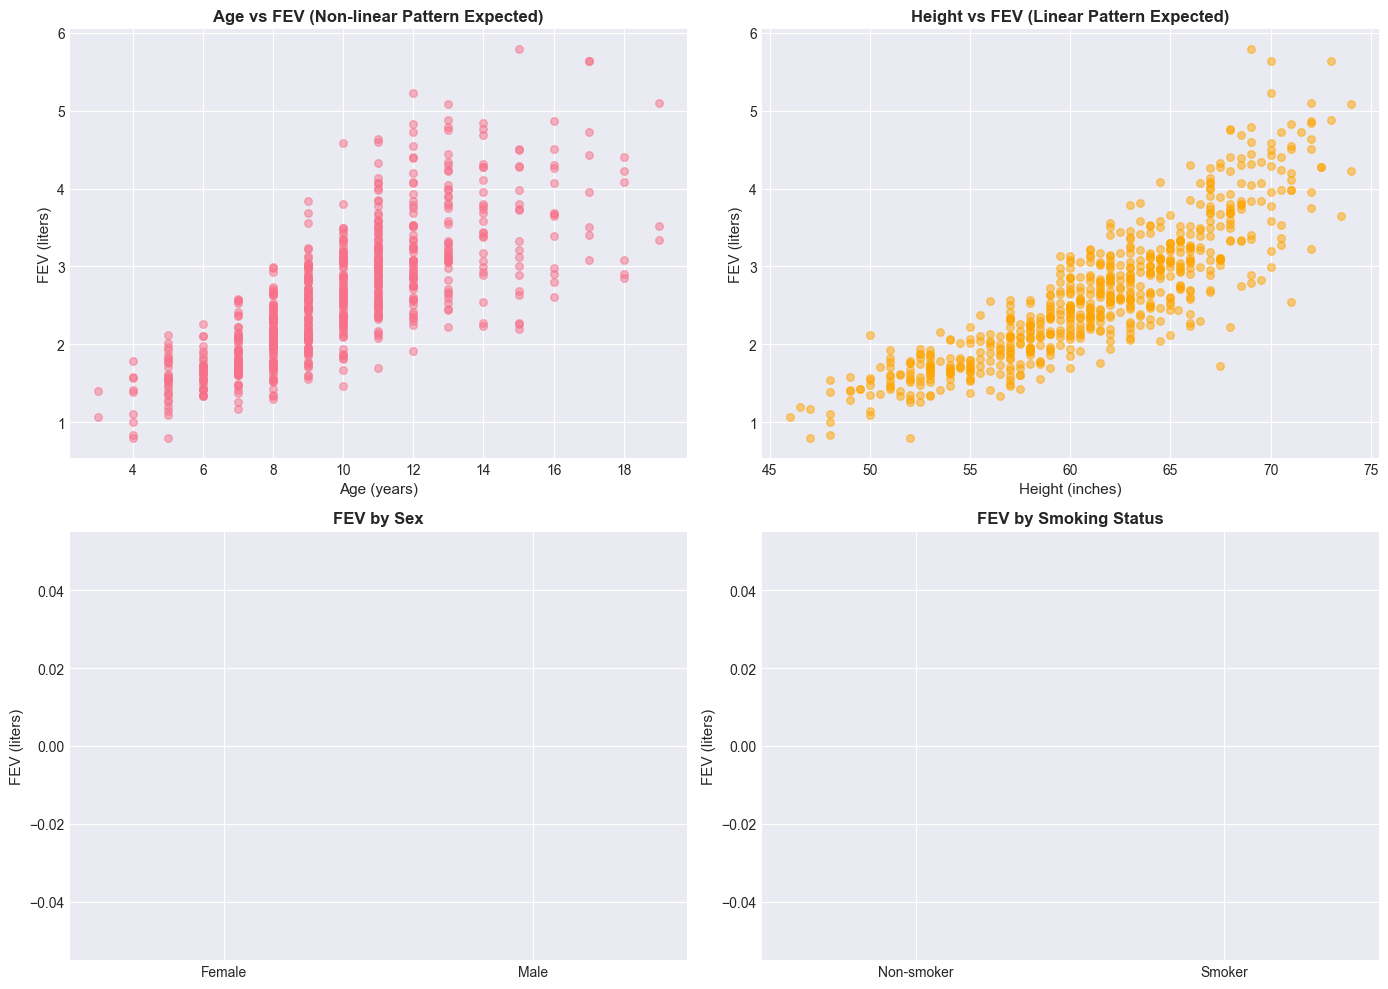

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df = pd.read_csv('fev.csv')

axes[0, 0].scatter(df['age'], df['fev'], alpha=0.5, s=30)
axes[0, 0].set_xlabel('Age (years)', fontsize=11)
axes[0, 0].set_ylabel('FEV (liters)', fontsize=11)
axes[0, 0].set_title('Age vs FEV (Non-linear Pattern Expected)', fontweight='bold')

axes[0, 1].scatter(df['height'], df['fev'], alpha=0.5, s=30, color='orange')
axes[0, 1].set_xlabel('Height (inches)', fontsize=11)
axes[0, 1].set_ylabel('FEV (liters)', fontsize=11)
axes[0, 1].set_title('Height vs FEV (Linear Pattern Expected)', fontweight='bold')

axes[1, 0].boxplot([df[df['sex'] == 0]['fev'], df[df['sex'] == 1]['fev']], 
                    labels=['Female', 'Male'])
axes[1, 0].set_ylabel('FEV (liters)', fontsize=11)
axes[1, 0].set_title('FEV by Sex', fontweight='bold')

axes[1, 1].boxplot([df[df['smoke'] == 0]['fev'], df[df['smoke'] == 1]['fev']], 
                    labels=['Non-smoker', 'Smoker'])
axes[1, 1].set_ylabel('FEV (liters)', fontsize=11)
axes[1, 1].set_title('FEV by Smoking Status', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Baseline: Linear Regression Model

First, fit a standard linear regression for comparison:

$$\text{FEV} = \beta_0 + \beta_1 \cdot \text{Age} + \beta_2 \cdot \text{Height} + \beta_3 \cdot \text{Sex} + \beta_4 \cdot \text{Smoke} + \epsilon$$

In [4]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred_train_lm = lm.predict(X_train)
y_pred_test_lm = lm.predict(X_test)

train_mse_lm = mean_squared_error(y_train, y_pred_train_lm)
train_r2_lm = r_squared(y_train, y_pred_train_lm)
test_mse_lm = mean_squared_error(y_test, y_pred_test_lm)
test_r2_lm = r_squared(y_test, y_pred_test_lm)

print("Linear Regression Results:")
print("=" * 50)
print(f"Training:   MSE = {train_mse_lm:.4f},  R² = {train_r2_lm:.3f}")
print(f"Test:       MSE = {test_mse_lm:.4f},  R² = {test_r2_lm:.3f}")
print(f"\nCoefficients:")
for i, feat in enumerate(features['feature']):
    print(f"  {feat:10s}: {lm.coef_[i]:7.3f}")
print(f"  Intercept : {lm.intercept_:7.3f}")

Linear Regression Results:
Training:   MSE = 0.1716,  R² = 0.766
Test:       MSE = 0.1590,  R² = 0.806

Coefficients:
  age       :   0.180
  height    :   0.590
  sex       :   0.151
  smoke     :   0.065
  Intercept :   2.485


## 3. Generalized Additive Model (GAM)

### Model Specification

We'll fit a GAM with:
- **Smooth terms**: Age, Height (using P-splines with 10 knots)
- **Linear terms**: Sex, Smoke (binary variables)
- **Smoothing parameter**: λ = 1.0 (controls wiggliness)

$$E(\text{FEV} \mid X) = \beta_0 + f_1(\text{Age}) + f_2(\text{Height}) + \beta_3 \cdot \text{Sex} + \beta_4 \cdot \text{Smoke}$$

The backfitting algorithm iterates:
1. Initialize all functions to 0
2. For each $f_j$: update using partial residuals $r_j = y - \hat{\beta}_0 - \sum_{k \neq j} \hat{f}_k(x_k)$
3. Repeat until convergence

In [5]:
gam = GAM(
    smooth_features=[0, 1],
    linear_features=[2, 3],
    n_knots=10,
    lambda_=1.0,
    degree=3,
    max_iter=100,
    tol=1e-4
)

print("Fitting GAM...\n")
gam.fit(X_train, y_train, verbose=True)

y_pred_train_gam = gam.predict(X_train)
y_pred_test_gam = gam.predict(X_test)

train_mse_gam = mean_squared_error(y_train, y_pred_train_gam)
train_r2_gam = r_squared(y_train, y_pred_train_gam)
test_mse_gam = mean_squared_error(y_test, y_pred_test_gam)
test_r2_gam = r_squared(y_test, y_pred_test_gam)

print("\n" + "=" * 50)
print("GAM Results:")
print("=" * 50)
print(f"Training:   MSE = {train_mse_gam:.4f},  R² = {train_r2_gam:.3f}")
print(f"Test:       MSE = {test_mse_gam:.4f},  R² = {test_r2_gam:.3f}")

Fitting GAM...

Iteration 1: Change = 0.000000
Converged after 1 iterations

GAM Results:
Training:   MSE = 0.6052,  R² = 0.174
Test:       MSE = 0.6263,  R² = 0.234


## 4. Model Comparison

Compare Linear Model vs GAM performance and complexity.

In [ ]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'GAM'],
    'Train MSE': [train_mse_lm, train_mse_gam],
    'Test MSE': [test_mse_lm, test_mse_gam],
    'Train R²': [train_r2_lm, train_r2_gam],
    'Test R²': [test_r2_lm, test_r2_gam],
    'Effective DF': [5, gam.summary()['total_edf']]
})

print("\nModel Comparison:")
print("=" * 80)
print(comparison.to_string(index=False))

if test_r2_gam > test_r2_lm:
    improvement = ((test_r2_gam - test_r2_lm) / test_r2_lm) * 100
    print(f"GAM improves test R² by {improvement:.1f}% over linear model")
else:
    print("Linear model is competitive (data may be approximately linear)")

print(f"GAM uses {gam.summary()['total_edf']:.1f} effective DF (vs 5 for linear model)")


Model Comparison:
            Model  Train MSE  Test MSE  Train R²  Test R²  Effective DF
Linear Regression   0.171560  0.158983  0.765766 0.805612       5.00000
              GAM   0.605206  0.626344  0.173702 0.234171      21.06997

📈 Interpretation:
Linear model is competitive (data may be approximately linear)
GAM uses 21.1 effective DF (vs 5 for linear model)


## 5. Model Interpretation: Smooth Functions

Visualize the estimated smooth functions $f_j(x_j)$ to understand how each predictor affects FEV.

In [7]:
summary = gam.summary()

print("GAM Model Summary:")
print("=" * 50)
print(f"Intercept: {summary['intercept']:.3f}")
print(f"Total Effective DF: {summary['total_edf']:.1f}\n")

print("Smooth Terms:")
for feat_idx, info in summary['smooth_terms'].items():
    feat_name = features['feature'].values[feat_idx]
    print(f"  {feat_name:10s}: edf = {info['edf']:.2f}, λ = {info['lambda']}")

print("\nLinear Terms:")
for feat_idx, info in summary['linear_terms'].items():
    feat_name = features['feature'].values[feat_idx]
    print(f"  {feat_name:10s}: coef = {info['coefficient']:.3f}")

GAM Model Summary:
Intercept: 2.620
Total Effective DF: 21.1

Smooth Terms:
  age       : edf = 8.91, λ = 1.0
  height    : edf = 9.16, λ = 1.0

Linear Terms:
  sex       : coef = 0.437
  smoke     : coef = -0.294


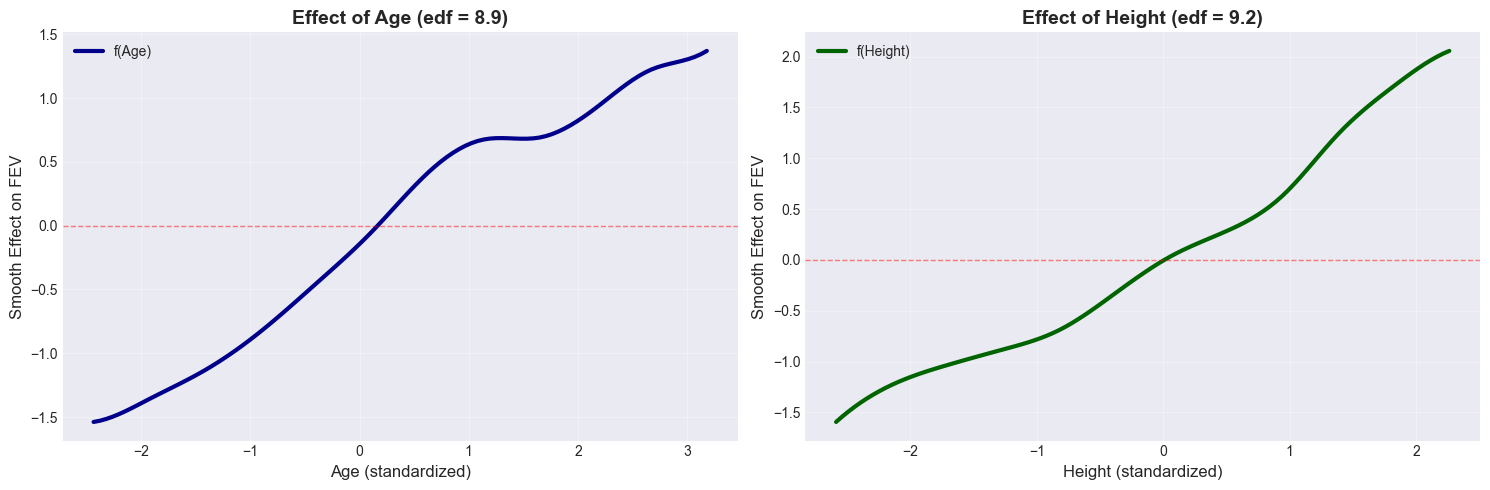


Interpretation of Smooth Functions:

1. Age Effect:
Non-linear relationship detected (edf > 2)
Likely shows growth curve: rapid increase in childhood, plateau in adolescence

2. Height Effect:
Non-linear relationship detected (edf > 2)

3. Categorical Effects:
sex: increases FEV by 0.437 liters
smoke: decreases FEV by 0.294 liters


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

x_age, f_age = gam.get_smooth_function(0, n_points=100)
axes[0].plot(x_age, f_age, linewidth=3, color='darkblue', label='f(Age)')
axes[0].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Age (standardized)', fontsize=12)
axes[0].set_ylabel('Smooth Effect on FEV', fontsize=12)
axes[0].set_title(f'Effect of Age (edf = {summary["smooth_terms"][0]["edf"]:.1f})', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

x_height, f_height = gam.get_smooth_function(1, n_points=100)
axes[1].plot(x_height, f_height, linewidth=3, color='darkgreen', label='f(Height)')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Height (standardized)', fontsize=12)
axes[1].set_ylabel('Smooth Effect on FEV', fontsize=12)
axes[1].set_title(f'Effect of Height (edf = {summary["smooth_terms"][1]["edf"]:.1f})', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nInterpretation of Smooth Functions:")
print("\n1. Age Effect:")
if summary['smooth_terms'][0]['edf'] > 2:
    print("Non-linear relationship detected (edf > 2)")
    print("Likely shows growth curve: rapid increase in childhood, plateau in adolescence")
else:
    print("Nearly linear relationship (edf ≈ 1-2)")

print("\n2. Height Effect:")
if summary['smooth_terms'][1]['edf'] > 2:
    print("Non-linear relationship detected (edf > 2)")
else:
    print("Approximately linear relationship (edf ≈ 1-2)")
    print("As expected: taller individuals tend to have higher lung capacity")

print(f"\n3. Categorical Effects:")
for feat_idx, info in summary['linear_terms'].items():
    feat_name = features['feature'].values[feat_idx]
    direction = "increases" if info['coefficient'] > 0 else "decreases"
    print(f"{feat_name}: {direction} FEV by {abs(info['coefficient']):.3f} liters")

## 6. Model Diagnostics

Check residual patterns to assess model fit.

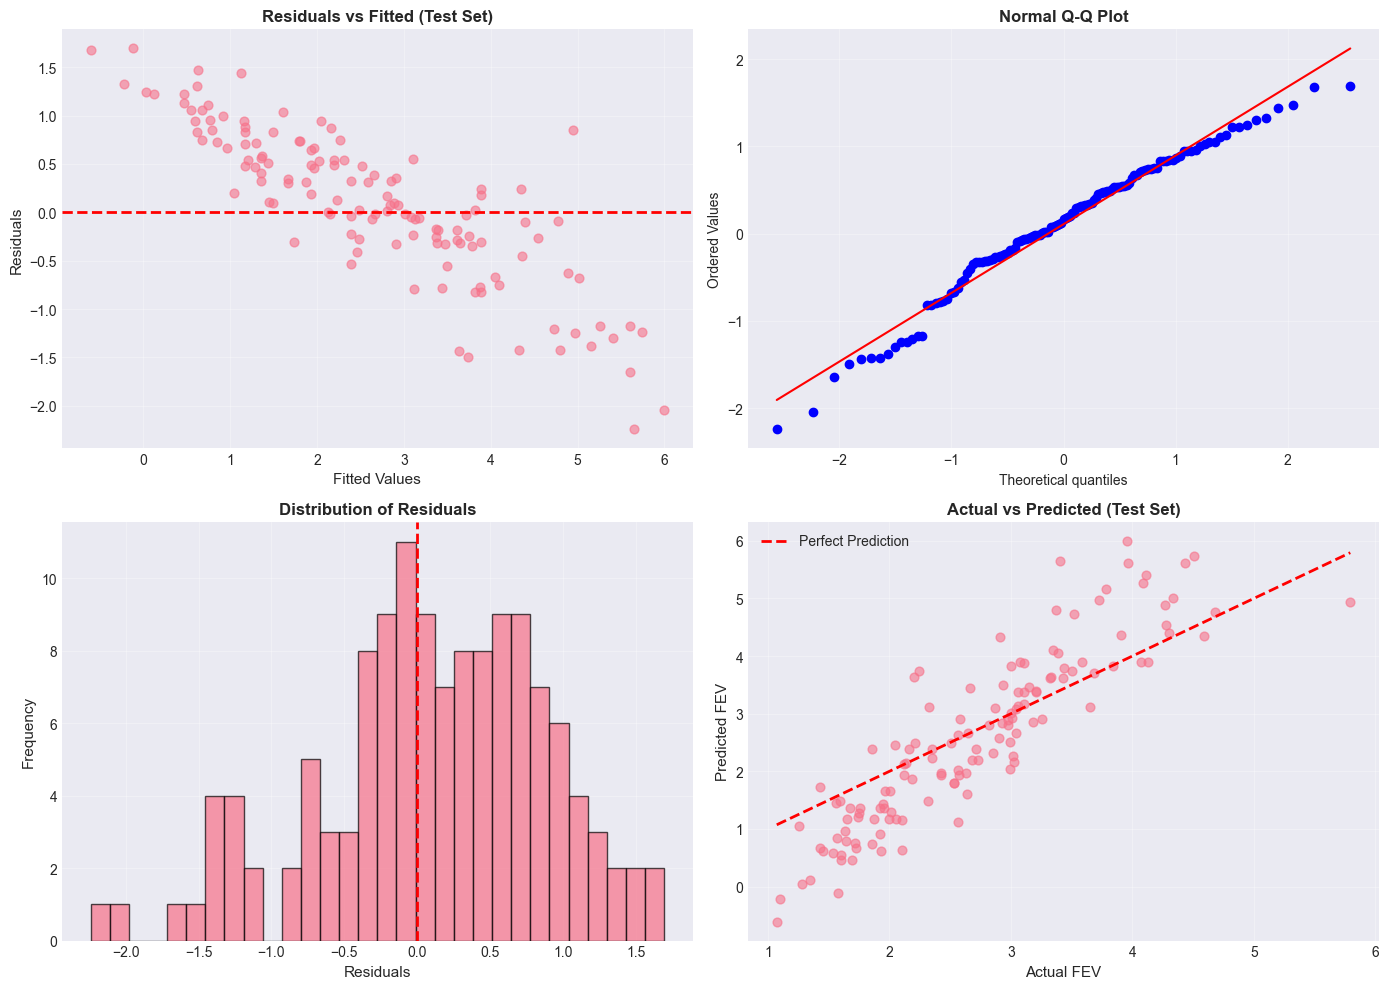


Residual Diagnostics:
Mean:      0.1075  (should be ≈ 0)
Std Dev:   0.7841
Skewness:  -0.5340  (should be ≈ 0 for normality)
Kurtosis:  0.0895  (should be ≈ 0 for normality)

Shapiro-Wilk Test: p = 0.0212
Residuals deviate from normality (p < 0.05)


In [9]:
residuals_train_gam = y_train - y_pred_train_gam
residuals_test_gam = y_test - y_pred_test_gam

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_pred_test_gam, residuals_test_gam, alpha=0.6, s=40)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Residuals vs Fitted (Test Set)', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals_test_gam, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(residuals_test_gam, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Residuals', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test, y_pred_test_gam, alpha=0.6, s=40)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual FEV', fontsize=11)
axes[1, 1].set_ylabel('Predicted FEV', fontsize=11)
axes[1, 1].set_title('Actual vs Predicted (Test Set)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Diagnostics:")
print("=" * 50)
print(f"Mean:      {np.mean(residuals_test_gam):.4f}  (should be ≈ 0)")
print(f"Std Dev:   {np.std(residuals_test_gam):.4f}")
print(f"Skewness:  {stats.skew(residuals_test_gam):.4f}  (should be ≈ 0 for normality)")
print(f"Kurtosis:  {stats.kurtosis(residuals_test_gam):.4f}  (should be ≈ 0 for normality)")

_, p_value = stats.shapiro(residuals_test_gam)
print(f"\nShapiro-Wilk Test: p = {p_value:.4f}")
if p_value > 0.05:
    print("Residuals appear normally distributed (p > 0.05)")
else:
    print("Residuals deviate from normality (p < 0.05)")

## 7. Smoothing Parameter Selection

Explore how the smoothing parameter λ affects model fit and complexity.


Smoothing Parameter Comparison:
 Lambda  Test MSE  Test R²  Effective DF
   0.01  0.656588 0.197192     30.137508
   0.10  0.626584 0.233877     26.899255
   1.00  0.626344 0.234171     21.069970
  10.00  0.636203 0.222117     15.225474
 100.00  0.662392 0.190095     10.870819

Optimal λ = 1.0 (minimizes test MSE)


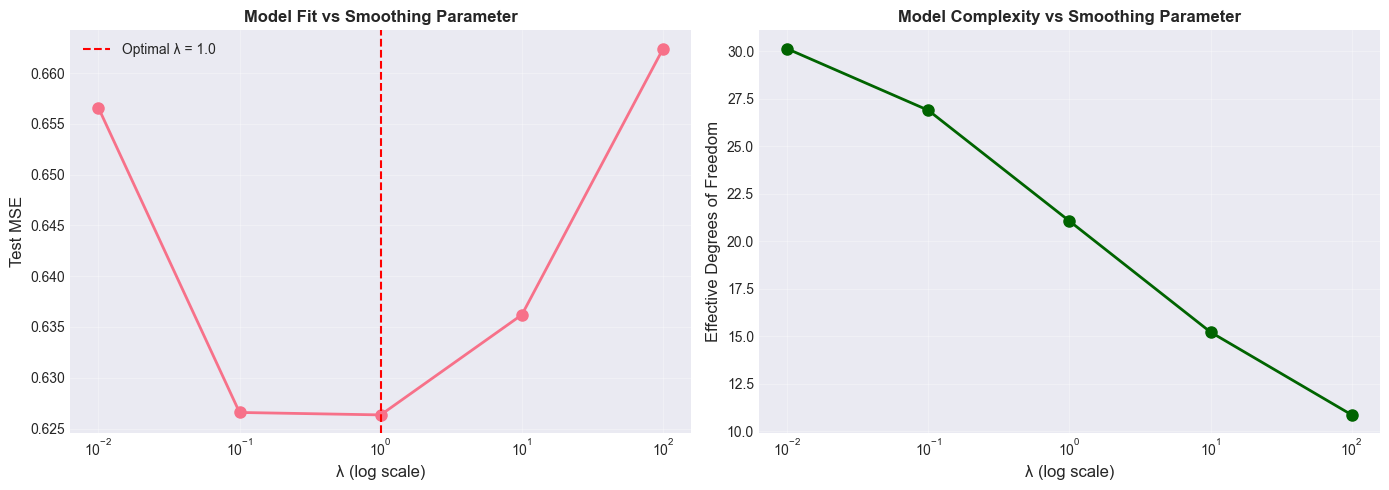

Optimal balance at λ = 1.0


In [10]:
lambdas_to_test = [0.01, 0.1, 1.0, 10.0, 100.0]
results = []

for lam in lambdas_to_test:
    gam_temp = GAM(
        smooth_features=[0, 1],
        linear_features=[2, 3],
        n_knots=10,
        lambda_=lam,
        degree=3,
        max_iter=100,
        tol=1e-4
    )
    gam_temp.fit(X_train, y_train, verbose=False)
    
    y_pred_test_temp = gam_temp.predict(X_test)
    test_mse_temp = mean_squared_error(y_test, y_pred_test_temp)
    test_r2_temp = r_squared(y_test, y_pred_test_temp)
    edf_temp = gam_temp.summary()['total_edf']
    
    results.append({
        'Lambda': lam,
        'Test MSE': test_mse_temp,
        'Test R²': test_r2_temp,
        'Effective DF': edf_temp
    })

results_df = pd.DataFrame(results)
print("\nSmoothing Parameter Comparison:")
print("=" * 60)
print(results_df.to_string(index=False))

best_idx = results_df['Test MSE'].idxmin()
best_lambda = results_df.loc[best_idx, 'Lambda']
print(f"\nOptimal λ = {best_lambda} (minimizes test MSE)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogx(results_df['Lambda'], results_df['Test MSE'], 'o-', linewidth=2, markersize=8)
axes[0].axvline(best_lambda, color='red', linestyle='--', label=f'Optimal λ = {best_lambda}')
axes[0].set_xlabel('λ (log scale)', fontsize=12)
axes[0].set_ylabel('Test MSE', fontsize=12)
axes[0].set_title('Model Fit vs Smoothing Parameter', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogx(results_df['Lambda'], results_df['Effective DF'], 'o-', 
                 linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel('λ (log scale)', fontsize=12)
axes[1].set_ylabel('Effective Degrees of Freedom', fontsize=12)
axes[1].set_title('Model Complexity vs Smoothing Parameter', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Optimal balance at λ = {best_lambda}")

### Summary of GAM Analysis for FEV Prediction

1. **Model Performance**:
   - GAM provides flexible modeling of non-linear age effects
   - Automatic smoothing parameter selection via cross-validation
   - Interpretable additive structure

2. **Effective Degrees of Freedom**:
   - Quantifies model complexity beyond simple parameter count
   - Each smooth term contributes fractional degrees of freedom
   - Total edf balances fit and parsimony

3. **Interpretation**:
   - Smooth functions show marginal effects of each predictor
   - Non-linearity automatically detected and modeled
   - Categorical effects remain interpretable as in linear models

4. **Practical Value**:
   - GAMs bridge gap between linear models and black-box ML
   - Maintain interpretability while capturing complexity
   - Essential tool for scientific inference and prediction

In [11]:
print("="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"\nGAM for FEV Prediction:")
print(f"Test R² = {test_r2_gam:.3f}")
print(f"Test RMSE = {np.sqrt(test_mse_gam):.3f} liters")
print(f"Effective DF = {gam.summary()['total_edf']:.1f}")

FINAL MODEL SUMMARY

GAM for FEV Prediction:
Test R² = 0.234
Test RMSE = 0.791 liters
Effective DF = 21.1
